# `toffee` : A library for fast access to DIA-MS data

Data generated by DIA-MS exists in proprietary data formats that are opaque to open-source software. Typically, a user will convert this data to the open `mzML` format before utilising a tool such as [OpenSWATH](http://openswath.org) for analysis. Unfortunately, the conversion of data formats results in a significant expansion in the file size, and as the downstream algorithms are largely I/O bound, this leads to an unneccessary increase in analysis time.

Based on the physics of mass analyzers, it is possible to create a more highly-compressed format whilst still retaining _profile_ raw data. Ultimately, this is an implementation of the Intrinsic Mass Spacing (IMS) as described in [Schneider (2016)](Schneider2016_Mass-Spectral-Data-Processing.pdf) and reflects the fact that mass analyzers a discrete sensors that operate in the time domain, and transform results into the mass over charge domain.

In order to investigate this fully, we took a Sciex SWATH-MS file from a recent run through the [ProCan](https://www.cmri.org.au/procan) facility, and a Thermo Q-Exacutive DIA RAW file from [Peckner2018](https://www.ebi.ac.uk/pride/archive/projects/PXD006722). Each of these raw files was converted to profile `mzML` using `msconvert` and then using `pyteomics` we extracted the raw m/z data and saved to HDF5 for fast read access. 

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import scipy
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output 
clear_output(wait=False)  # clear import errors that aren't useful for tutorial

sns.set()
sns.set_color_codes()

base_dir = os.environ.get('DIA_TEST_DATA_REPO', None)
assert base_dir is not None

## Sciex / Time of Flight (TOF) Mass Analyzers

We recognised an opportunity to represent SWATH-MS data in a different form based on the physics of Time of Flight (TOF) detection (see [wikipedia](https://en.wikipedia.org/wiki/Time-of-flight_mass_spectrometry)). 

### Time of Flight Physics

We know that the ions, of charge $q$, are passed through an electric potential $U$

$$
E_p = qU
$$

and will result in a kinetic energy

$$
E_k = \frac{1}{2} m v^2
$$

assuming no acceleration in the TOF tube (of length $d$), then velocity $v=d/t$. Equating the energies and solving for time we get

$$
t = \frac{d}{\sqrt{2U}}\sqrt{\frac{m}{q}}.
$$

From here, we can calculate a relationship between $\Delta t$ and $\Delta \sqrt{m/q}$

$$
t_1 = \frac{d}{\sqrt{2U}}\sqrt{m/q_1}
$$
$$
t_2 = \frac{d}{\sqrt{2U}}\sqrt{m/q_2}
$$
$$
\Delta t = t_2 - t_1 = \frac{d}{\sqrt{2U}}\left(\sqrt{m/q_2}-\sqrt{m/q_1}\right)
$$

Thus, if there is a discrete and constant spacing in $\Delta t$ due to the physics of the detector, we can assume there will be a discrete and constant spacing of $\sqrt{m/q_2}-\sqrt{m/q_1}$. 

$$
\Delta t = \frac{1}{\alpha} \Delta \sqrt{m/q}
$$

[Schneider (2016)](Schneider2016_Mass-Spectral-Data-Processing.pdf) refers to this, $\alpha$, as the Intrinsic Mass Spacing (IMS).

In [2]:
class CalculatorTOF(object):
    IMS_TRANSFORM = 'sqrt(m/z)'
    FNAME = base_dir + '/ProCan90/ProCan90-M03-01.ms2-050.h5'

    def __init__(self, mz):
        self.mz = mz
        self.root_mz = np.sqrt(mz)
        
    def calculate_ims_params_directly(self):
        delta_root_mz = np.abs(np.diff(self.root_mz))
        min_delta_root_mz = delta_root_mz.min()
        min_alpha_list = delta_root_mz[delta_root_mz <= 1.4 * min_delta_root_mz]
        alpha = np.median(min_alpha_list)
        alpha_mad = np.median(np.abs(min_alpha_list - alpha))

        beta = -np.mean(self.residual([alpha, 0.0]))
        return alpha, alpha_mad, beta
    
    @classmethod
    def calculate_deltas_in_ims_space(cls, mz):
        root_mz = np.sqrt(mz)
        return np.diff(root_mz)

    def residual_ppm(self, params, offset=0):
        return self.residual(params, offset=offset) * 1e6 / self.mz

    def residual(self, params, offset=0):
        return self._func(params, offset=offset) - self.mz
    
    def ims_coord(self, params, offset=0):
        a, b = params
        i = (self.root_mz - b) / a
        return np.around(i, decimals=0) + offset

    def _func(self, params, offset=0):
        a, b = params
        i = self.ims_coord(params, offset=offset)
        return (a * i + b) ** 2

This raw data is plotted below for both an MS1 window and the middle MS2 window where the x-axis is m/z and the y-axis plots the difference between consecutive m/z values in the raw data.

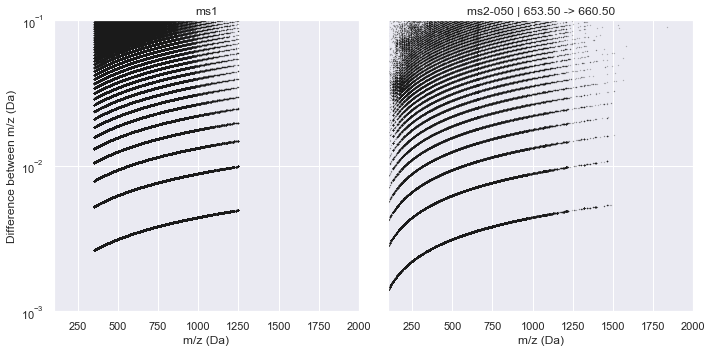

In [3]:
def plot_raw_deltas(Calculator, xlim, ylim):
    fname = Calculator.FNAME
    windows = ['ms1', 'ms2-050']
    ncols = len(windows)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5), num=1, sharey=True, sharex=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    with h5py.File(fname, 'r') as f:
        for (window_name, ax) in zip(windows, axes):
            window = f[window_name]
            title = window_name
            if window_name != 'ms1':
                title += ' | {:.2F} -> {:.2F}'.format(window.attrs['lower'], window.attrs['upper'])
            ax.set_title(title)

            for scan_key in list(window.keys())[500:700]:
                mz = window[scan_key]['mz'].value
                ax.semilogy(mz[1:], np.diff(mz), 'k.', ms=0.5, alpha=0.5)

    for ax in axes:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('m/z (Da)')
    axes[0].set_ylabel('Difference between m/z (Da)')
    fig.tight_layout()
    
plot_raw_deltas(CalculatorTOF, xlim=(100, 2000), ylim=(1e-3, 1e-1))

It is clear from this plot that a consistent pattern emerges. From visual inspection, this seems to match our hypothesis of a $\sqrt{m/z}$ relationship. Indeed, if we plot this along the y-axis, the Intrinsic Mass Spacing of the TOF spectrum becomes obvious. The figure below mimics Figure 3.2 of [Schneider (2016)](Schneider2016_Mass-Spectral-Data-Processing.pdf) where the lowest set of data is the IMS and each line above that represents an integer multiple of the IMS. This can be seen clearly by the red lines that show the first 10 multiples of the IMS. The IMS multiplier minus one indicates the number of missing data points in the spectrum (likely due to no ions hitting the detector during this time).

ms1     :: IMS alpha = 7.01547425e-05 +/- 4.462e-11
ms2-050 :: IMS alpha = 7.01547256e-05 +/- 4.387e-11


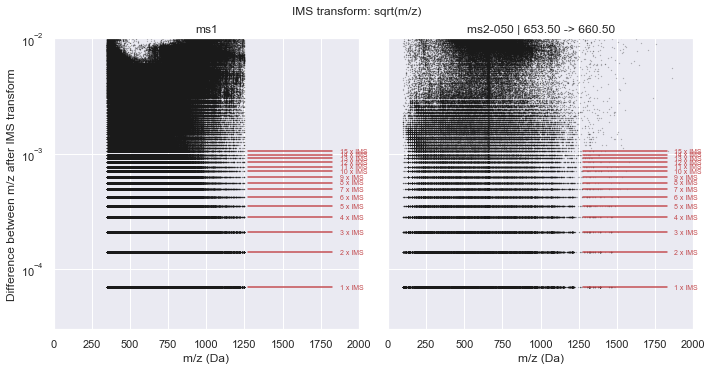

In [4]:
def plot_in_ims_space(Calculator, xlim, ylim):
    fname = Calculator.FNAME
    windows = ['ms1', 'ms2-050']
    ncols = len(windows)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5), num=1, sharey=True, sharex=True)
    with h5py.File(fname, 'r') as f:
        for (window_name, ax) in zip(windows, axes):
            window = f[window_name]
            
            title = window_name
            if window_name != 'ms1':
                title += ' | {:.2F} -> {:.2F}'.format(window.attrs['lower'], window.attrs['upper'])
            ax.set_title(title)
            
            min_list = list()
            for scan_key in list(window.keys())[500:700]:
                mz = window[scan_key]['mz'].value
                deltas_ims = Calculator.calculate_deltas_in_ims_space(mz)
                ax.semilogy(mz[1:], deltas_ims, 'k.', ms=0.5, alpha=0.5)
                min_val = deltas_ims.min()
                min_list.extend(list(deltas_ims[deltas_ims < 1.1 * min_val]))
            
            min_list = np.array(min_list)
            min_val = min_list.min()
            min_list = min_list[min_list < 1.1 * min_val]
            min_ims_alpha, stddev_min_ims_alpha = np.mean(min_list), np.std(min_list)

            fmt = '{:<7s} :: IMS alpha = {:.8e} +/- {:.3e}'
            print(fmt.format(window_name, min_ims_alpha, stddev_min_ims_alpha))

            multipliers = [i + 1 for i in range(15)]
            for multiplier in multipliers:
                ims = multiplier * min_ims_alpha
                ax.plot([1275, 1825], [ims, ims], 'r-')
                ax.text(
                    1875,
                    ims,
                    '{} x IMS'.format(multiplier),
                    horizontalalignment='left',
                    verticalalignment='center',
                    color='r',
                    fontsize=7,
                )

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel('m/z (Da)')
            
    axes[0].set_ylabel('Difference between m/z after IMS transform')
    fig.tight_layout()
    fig.suptitle('IMS transform: ' + Calculator.IMS_TRANSFORM, y=1.02)
    
plot_in_ims_space(CalculatorTOF, xlim=(0, 2000), ylim=(3e-5, 1e-2))

It is clear from this plot that a consistent pattern emerges. From visual inspection, this seems to match our hypothesis of a $\sqrt{m/z}$ relationship. Indeed, if we plot this along the y-axis, the Intrinsic Mass Spacing of the TOF spectrum becomes obvious. The figure below mimics Figure 3.2 of [Schneider (2016)](Schneider2016_Mass-Spectral-Data-Processing.pdf) where the lowest set of data is the IMS and each line above that represents an integer multiple of the IMS. This can be seen clearly by the red lines that show the first 10 multiples of the IMS. The IMS multiplier minus one indicates the number of missing data points in the spectrum (likely due to no ions hitting the detector during this time).

### Using IMS for data compression

Knowing that the m/z data is driven by an integer relationship with the IMS allows two opportunities for **near-lossless** data compression:

1. We can drop any $m/z$ values with corresponding zero intensities as these data points can be added back to the spectrum without losing fidelity
2. We can store the IMS value as a double, and convert the $m/z$ vector to a vector of unsigned 32-bit integers that represent an index

The relationship to convert between vectors is summarised as

$$
\frac{m}{z} = \left( \alpha_{IMS} i_{\sqrt{m/z}} + \beta_{trunc} \right)^2
$$

where $\alpha_{IMS}$ is the IMS value, $i_{\sqrt{m/z}}$ is the unsigned integer index of the $m/z$ value in $\sqrt{m/z}$ space, and $\beta_{trunc}$ is to control for any truncation error that may be introduced from the mzML file.

In the figure below, we plot out (in black) the mass error, in ppm, of the converted mass over charge compared to the values collected from the mzML. The red dots indicate the mass error if the index ($i_{\sqrt{m/z}}$) is offset by $0.25$ in either direction. In general, this shows that the bounds of the indices are tight, but there is a latent mass error that comes from translating the floating-point $m/z$ value into integer space.

## Thermo / Orbitrap

Old
$$
\Delta t = \frac{1}{\alpha} \left( \Delta \sqrt{m/z} - \beta \right)
$$
$$
i = \frac{\sqrt{m/z} - \beta}{\alpha} - \gamma
$$
$$
(i + \gamma) \alpha + \beta = \sqrt{m/z}
$$
therefore,
$$
m/z = ((i + \gamma) \alpha + \beta)^2
$$

New

$$
\Delta t = \frac{1}{\alpha} \left( \Delta \frac{1}{\sqrt{m/z}} - \beta \right)
$$
$$
i = \frac{1}{\alpha} \left( \frac{1}{\sqrt{m/z}} - \beta \right) - \gamma
$$
$$
(i + \gamma) \alpha + \beta = \frac{1}{\sqrt{m/z}}
$$
$$
m/z = \frac{1}{((i + \gamma) \alpha + \beta)^2}
$$

where $\gamma$ is the minimum value of the IMS coords such that these are zero-indexed in the file

In [6]:
class CalculatorOrbitrap(object):
    IMS_TRANSFORM = '1 / sqrt(m/z)'
    FNAME = base_dir + '/thermo/CC20160706_P100_Plate34_PC3_T3_P-0034_A01_acq_01.h5'

    def __init__(self, mz):
        self.mz = mz
        self.inverse_root_mz = 1 / np.sqrt(mz)
        
    def calculate_ims_params_directly(self):
        delta_root_mz = -np.abs(np.diff(self.inverse_root_mz))
        min_delta_root_mz = delta_root_mz.max()
        min_alpha_list = delta_root_mz[delta_root_mz >= 1.4 * min_delta_root_mz]
        alpha = np.median(min_alpha_list)
        alpha_mad = np.median(np.abs(min_alpha_list - alpha))

        beta = -np.mean(self.residual([alpha, 0.0]))
        return alpha, alpha_mad, beta
    
    @classmethod
    def calculate_deltas_in_ims_space(cls, mz):
        inverse_root_mz = 1 / np.sqrt(mz)
        return -np.diff(inverse_root_mz)

    def residual_ppm(self, params, offset=0):
        return self.residual(params, offset=offset) * 1e6 / self.mz

    def residual(self, params, offset=0):
        return self._func(params, offset=offset) - self.mz
    
    def ims_coord(self, params, offset=0):
        a, b = params
        i = (self.inverse_root_mz - b) / a
        return np.around(i, decimals=0) + offset

    def _func(self, params, offset=0):
        i = self.ims_coord(params, offset=offset)
        a, b = params
        return (a * i + b) ** -2

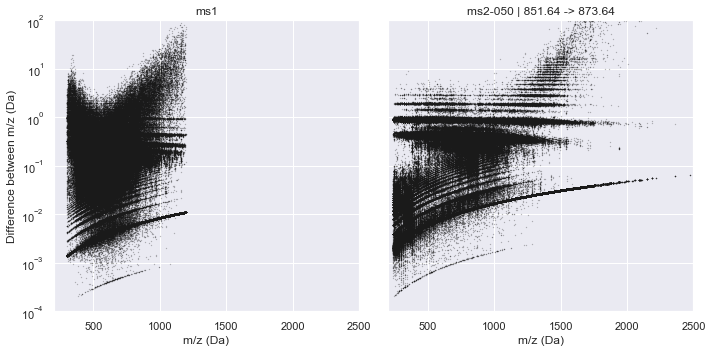

In [7]:
plot_raw_deltas(CalculatorOrbitrap, xlim=(200, 2500), ylim=(1e-4, 1e2))

ms1     :: IMS alpha = 1.34410614e-08 +/- 1.244e-10
ms2-050 :: IMS alpha = 2.68852104e-08 +/- 2.746e-10


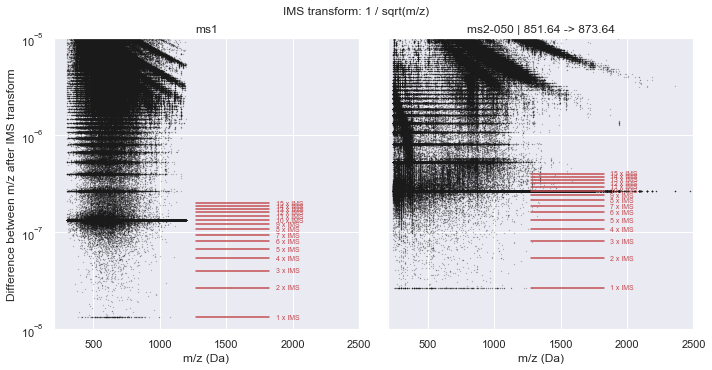

In [8]:
plot_in_ims_space(CalculatorOrbitrap, xlim=(200, 2500), ylim=(1e-8, 1e-5))

## Scan data saved as a point cloud

If we consider the raw data collected within a given window across a full gradient during a SWATH-MS run, each data point represents:

- *Mass over charge:* The abscissa refers to the mass over charge ratio of the peptide ion
- *Retention time:* The ordinate refers to the time at which the peptide ion is elutes from the Liquid Chromatography column
- *Intensity:* The applicate is a count of the number of times a peptide ion is detected on the sensor

We have shown that mass over charge can be represented by an unsigned integer, as can intensity. Furthermore, the retention time for each data point can be considered as an index into an associated (but much smaller) vector of doubles. In this manner, we can save the raw data into a file format as 3 vectors of unsigned 32-bit integers with some associated metadata. 

`toffee` takes this exact approach, saving each SWATH window as a group in an [HDF5](https://www.hdfgroup.org/HDF5) file. Each group has:

- `double` attributes `lower`, `center`, and `upper` to describe the properties of the window;
- `double` attributes `scanCycleTime` ($t_c$) and `firstScanRetentionTimeOffset` ($t_0$) that describe the retention time vector for each window such that $t(i) = t_c i + t_0$ in seconds;
- a `uint32` dataset of `retentionTimeIdx`, of equal length as the retention time vector, that represents indices into the `mzIMSCoord` and `intensity` between which the corresponding value of $t(i)$ is applied;
- `double` attributes `imsAlpha` ($\alpha_{IMS}$) and `imsBeta` ($\beta_{trunc}$) for the Intrinsic Mass Spacing m/z conversion such that $\frac{m}{z} = \left( \alpha_{IMS} i_{\sqrt{m/z}} + \beta_{trunc} \right)^2$; and
- `uint32` datasets of `mzIMSCoord` and `intensity` for the point cloud, with one entry for each point in the cloud.

In taking this approach, we have found a file format with **lossless** compression that can represent a SWATH-MS `mzML` file with a ten-fold decrease in the file size.

| File | `wiff` File Size (MB) | `toffee` File Size (MB) | `mzML` File Size (MB) | `toffee` Percent of `wiff` |
| --- | --- | --- | --- | --- |
| ProCan90-M03-01 | 576.06 | 533.25 | 5,596.73 | 92.57 |
| ProCan90-M06-01 | 779.12 | 732.04 | 7,555.10 | 93.95 |

| Property | `wiff` File Size (GB) | `toffee` File Size (GB) | `mzML` File Size (GB) | `toffee` Percent of `wiff` | `mzML` Percent of `wiff` |
| --- | --- | --- | --- | --- | --- |
| count | 90 | 90 | 90 | 90 | 90 |
| mean | 1.12 | 1.08 | 11.02 | 96.81 | 984.17 |
| std | 0.27 | 0.26 | 2.77 | 3.13 | 16.72 |
| min | 0.54 | 0.49 | 5.14 | 91.95 | 952.54 |
| 25% | 0.93 | 0.95 | 8.91 | 95.77 | 973.97 |
| 50% | 1.21 | 1.17 | 12.02 | 96.60 | 986.83 |
| 75% | 1.28 | 1.24 | 12.72 | 97.27 | 995.92 |
| max | 1.57 | 1.54 | 16.09 | 106.05 | 1021.46 |

![Toffee file sizes](tof_file_sizes.png "Toffee file sizes")